### 1. Preliminaries

In [73]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
import utils as ut

In [2]:
PATH_CLUSTERS = '../Results/clusters_Bayes_full_v1/'

CLUSTER_NAMES = ['Blocking', 'NAO -', 'NAO +', 'Atl. Ridge']

PATH_ANOM = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_anomaly/"
PATH_ZG500 = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_d/"

df = pd.read_csv(PATH_CLUSTERS + 'clusters_full.csv', index_col=0)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].apply(lambda dt: dt.replace(hour=12, minute=0, second=0)) # set time to noon, to match df. Is daily average anyway

In [3]:
PATH_ED = '/energydroughts-Europe/data/'
# ped = pd.read_csv(os.path.join(PATH_ED, 'PED_residual_q0.97_winter_LENTIS_PD_02_v4.csv')).reset_index(drop=True)
ed = pd.read_csv(os.path.join(PATH_ED, 'netto_demand_el7_winter_LENTIS_2023_PD_1600_events.csv')).reset_index(drop=True)
ed['run'] = ed['runs'].str.extract('(\d+)').astype(int)
df_events = ed.drop(['Unnamed: 0', 'runs'], axis = 1)

### 2. Defining functions

In [5]:
def calculate_persistency_stats(df, date_col='time', cluster_col='cluster_id'):
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Calculate the difference in days within each cluster
    df['date_diff'] = df.groupby(cluster_col)[date_col].diff().dt.days
    df['new_streak'] = (df['date_diff'] != 1)
    
    # Create a new group identifier for each streak
    df['streak_id'] = df.groupby(cluster_col)['new_streak'].cumsum()
    
    # Calculate the length of each streak
    streak_lengths = df.groupby([cluster_col, 'streak_id']).size().reset_index(name='streak_length')
    
    # Calculate the average, median, standard deviation, and maximum persistency
    persistency_stats = streak_lengths.groupby(cluster_col).agg(['mean', 'median', 'std', 'max'])
    
    return persistency_stats, streak_lengths

In [ ]:
def cluster_length(cluster_id, df_event_wr, df, streak_lengths_Bayes):
    """
    Calculate and plot the mean streak lengths for a given weather regime cluster, 
    comparing event-specific means to the overall mean streak length for that cluster.
    
    Args:
    cluster_id (int): The ID of the cluster whose streak lengths are to be analyzed.
    df_event_wr (DataFrame): DataFrame containing event and weather regime information.
    df (DataFrame): DataFrame containing just weather regime data for matching and querying purposes.
    streak_lengths_Bayes (DataFrame): DataFrame containing streak lengths for Bayesian clusters.
    
    Returns:
    tuple: A tuple containing the mean streak length for the events and the overall mean streak length.
    """
    
    streak_lengths_copy = streak_lengths_Bayes.copy()

    streak_length_array = []
    
    df_events_regime = df_event_wr.query('dominant_weather_regime == @cluster_id')
    
    for ind, row in tqdm(df_events_regime.iterrows(), total=df_events_regime.shape[0]):
        run = row['run']
        start_time = pd.to_datetime(row['start_time'])
        
        first_time_index = np.where(np.array(row['weather_regime_ids']) == cluster_id)[0][0]
        streak_time = start_time + pd.Timedelta(days=first_time_index)
        
        try:
            streak_id = df.query('run == @run and time == @streak_time')['streak_id'].values[0]
            streak_length = streak_lengths_copy.query('Bayes_cluster == @cluster_id and streak_id == @streak_id')
            streak_length_value = streak_length['streak_length'].values[0]
            streak_length_array.append(streak_length_value)
            streak_lengths_copy = streak_lengths_copy.drop(streak_length.index)
        except IndexError:
            continue

    streak_length_all = streak_lengths_Bayes.query('Bayes_cluster == @cluster_id')['streak_length'].values
    full_mean = np.mean(streak_length_all)
    event_mean = np.mean(streak_length_array)

    plt.figure()
    plt.hist(streak_length_all, color='C0', alpha=0.3)
    plt.hist(streak_length_array, color='r', alpha=0.5)    
    plt.axvline(event_mean, color='r', linestyle='dashed', linewidth=1, label='Event mean')
    plt.axvline(full_mean, color='C0', linestyle='dashed', linewidth=1, label='Full regime mean')
    plt.xlabel('Persistence [days]')
    plt.ylabel('Count')
    plt.title(f'Regime: {CLUSTER_NAMES[cluster_id]}')
    plt.legend()
    plt.show()

    return event_mean, full_mean

In [7]:
def plot_all_clusters(df, run):
    fig, axs = plt.subplots(2, 3, figsize=(20, 12),
                            subplot_kw={'projection': ccrs.Orthographic(central_longitude=-30, central_latitude=50)})

    for i, ax in enumerate(axs.flat):
        if i == 5:  # Adjust the condition to handle less than 6 clusters
            ax.axis('off')  # Turn off the axes for empty subplots
            continue
        else:
            cluster_id = i
            mask = (df['run'] == run) & (df['cluster_id'] == cluster_id)
            times = df.loc[mask, 'time']

            filename_anom = f"{PATH_ANOM}anom_zg500_d_ECEarth3_h{run:03d}.nc"
            filename = f"{PATH_ZG500}zg500_d_ECEarth3_h{run:03d}.nc"
            ds = xr.open_dataset(filename_anom)
            ds_full = xr.open_dataset(filename)

            ds = ds.where(
                (ds['time'].dt.month.isin([12, 1, 2])) &
                (ds['lon'] < 30) &
                (ds['lat'] > 20) &
                (ds['lat'] < 80),
                drop=True
            )

            ds_full = ds_full.where(
                (ds_full['time'].dt.month.isin([12, 1, 2])) &
                (ds_full['lon'] < 30) &
                (ds_full['lat'] > 20) &
                (ds_full['lat'] < 80),
                drop=True
            )

            vals = ds.sel(time = times.tolist()).zg500.mean(dim = 'time').values
            vals_contour = ds_full.sel(time = times.tolist()).zg500.mean(dim = 'time').values
            min_val = np.floor(np.min(vals_contour) / 100) * 100
            max_val = np.ceil(np.max(vals_contour) / 100) * 100

            levels = np.arange(min_val, max_val, 100)
            lons = ds.zg500['lon'].values
            lats = ds.zg500['lat'].values

            fill = ax.contourf(
                lons,
                lats,
                vals,
                levels = np.linspace(-200, 200, 41),
                cmap=plt.cm.RdBu_r,
                extend = 'both',
                transform=ccrs.PlateCarree())

            cs = ax.contour(
                lons,
                lats,
                vals_contour,
                levels = levels,
                transform = ccrs.PlateCarree(),
                colors = 'k'
            )

            ax.clabel(cs, inline=True, fontsize=10)

            cb = plt.colorbar(fill,
                            orientation='vertical',
                            label='500 hPa height anomaly [m]',
                            extend='both',
                            ax=ax)
            ax.coastlines(resolution='50m')
            ax.gridlines()
            ax.set_title(f"Cluster {cluster_id}")

    plt.tight_layout()
    plt.show()

In [8]:
def plot_correlating_clusters(df, run, corr_min, corr_max):
    fig, axs = plt.subplots(2, 2, figsize=(13, 8),
                            subplot_kw={'projection': ccrs.Orthographic(central_longitude=-30, central_latitude=50)})

    for i, ax in enumerate(axs.flat):
        cluster_id = i
        mask = (df['run'] == run) & (df['cluster_id'] == cluster_id) & (df['correlation'] >= corr_min) & (df['correlation'] <= corr_max)
        times = df.loc[mask, 'time']

        filename_anom = f"{PATH_ANOM}anom_zg500_d_ECEarth3_h{run:03d}.nc"
        filename = f"{PATH_ZG500}zg500_d_ECEarth3_h{run:03d}.nc"
        ds = xr.open_dataset(filename_anom)
        ds_full = xr.open_dataset(filename)

        ds = ds.where(
            (ds['time'].dt.month.isin([12, 1, 2])) &
            (ds['lon'] < 30) &
            (ds['lat'] > 20) &
            (ds['lat'] < 80),
            drop=True
        )

        ds_full = ds_full.where(
            (ds_full['time'].dt.month.isin([12, 1, 2])) &
            (ds_full['lon'] < 30) &
            (ds_full['lat'] > 20) &
            (ds_full['lat'] < 80),
            drop=True
        )
        if len(times) > 0:
            vals = ds.sel(time = times.tolist()).zg500.mean(dim = 'time').values
            vals_contour = ds_full.sel(time = times.tolist()).zg500.mean(dim = 'time').values
            min_val = np.floor(np.min(vals_contour) / 100) * 100
            max_val = np.ceil(np.max(vals_contour) / 100) * 100

            levels = np.arange(min_val, max_val, 100)
            lons = ds.zg500['lon'].values
            lats = ds.zg500['lat'].values

            fill = ax.contourf(
                lons,
                lats,
                vals,
                levels = np.linspace(-200, 200, 41),
                cmap=plt.cm.RdBu_r,
                extend = 'both',
                transform=ccrs.PlateCarree())

            cs = ax.contour(
                lons,
                lats,
                vals_contour,
                levels = levels,
                transform = ccrs.PlateCarree(),
                colors = 'k'
            )

            ax.clabel(cs, inline=True, fontsize=10)

            cb = plt.colorbar(fill,
                            orientation='vertical',
                            label='500 hPa height anomaly [m]',
                            extend='both',
                            ax=ax)
            ax.coastlines(resolution='50m')
            ax.gridlines()
            ax.set_title(f"Cluster {cluster_id}")

    plt.tight_layout()
    plt.show()

### 3. Checking cluster statistics

In [9]:
pers_stats, streak_lengths = calculate_persistency_stats(df)

In [10]:
pers_stats_Bayes, streak_lengths_Bayes = calculate_persistency_stats(df, cluster_col = 'Bayes_cluster')

In [74]:
df_event_wr = ut.find_dominant_wr(df_events, df, cluster_col = 'Bayes_cluster')

  0%|          | 0/13395 [00:00<?, ?it/s]

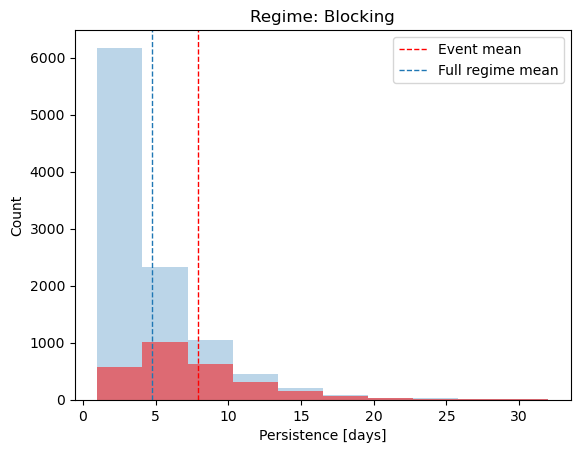

  0%|          | 0/13811 [00:00<?, ?it/s]

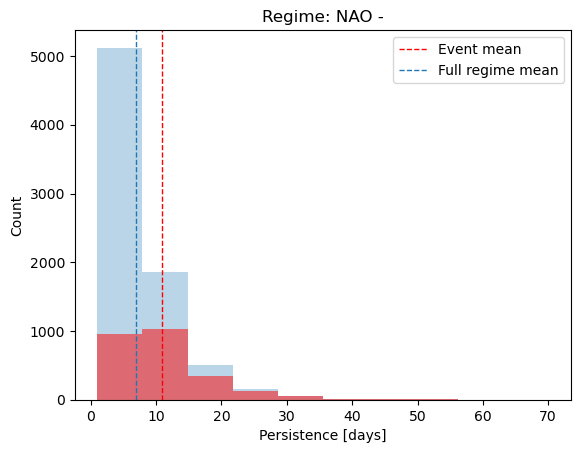

  0%|          | 0/2923 [00:00<?, ?it/s]

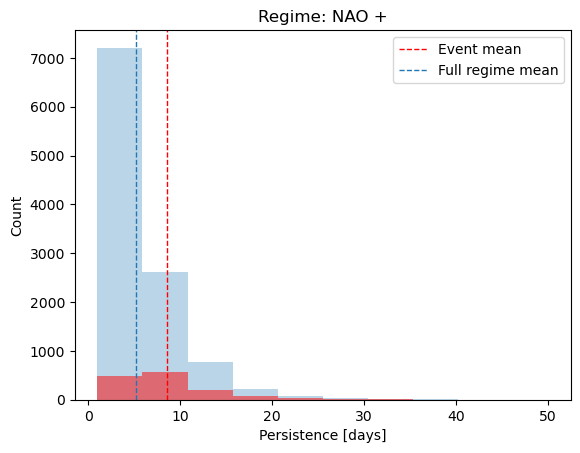

  0%|          | 0/5864 [00:00<?, ?it/s]

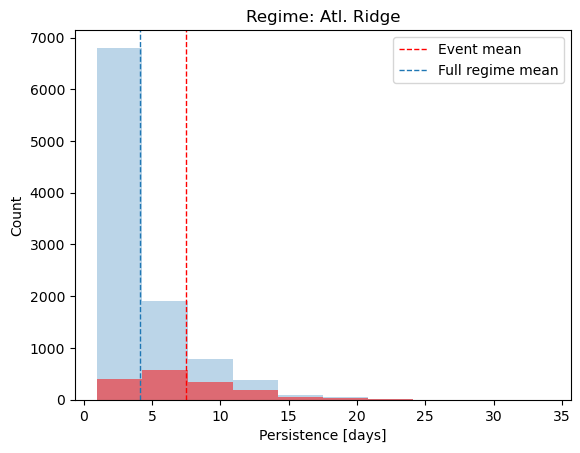

In [68]:
event_mean_list = []
full_mean_list = []
for i in range(4):
    event_mean, full_mean = cluster_length(i, df_event_wr, df, streak_lengths_Bayes)
    event_mean_list.append(event_mean)
    full_mean_list.append(full_mean)

### Stats visualisations

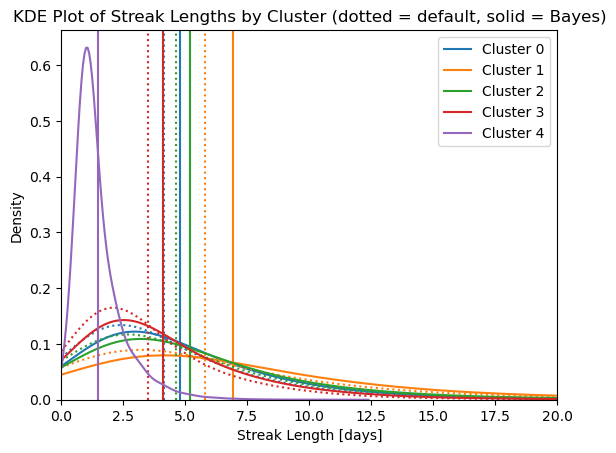

In [11]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

for cluster_id in range(5):
    color = colors[cluster_id]
    cluster_data_Bayes = streak_lengths_Bayes[streak_lengths_Bayes['Bayes_cluster'] == cluster_id]['streak_length']
    plt.axvline(np.mean(cluster_data_Bayes), color = color)
    cluster_data = streak_lengths[streak_lengths['cluster_id'] == cluster_id]['streak_length']
    plt.axvline(np.mean(cluster_data), color = color, linestyle = 'dotted')
    sns.kdeplot(cluster_data_Bayes, color = color, label=f'Cluster {cluster_id}', bw_method=0.5, clip = (0, 100))
    sns.kdeplot(cluster_data, color = color, linestyle="dotted", bw_method=0.5, clip = (0, 100))

# Add labels and title
plt.xlabel('Streak Length [days]')
plt.ylabel('Density')
plt.title('KDE Plot of Streak Lengths by Cluster (dotted = default, solid = Bayes)')
plt.xlim(0, 20)
plt.legend()

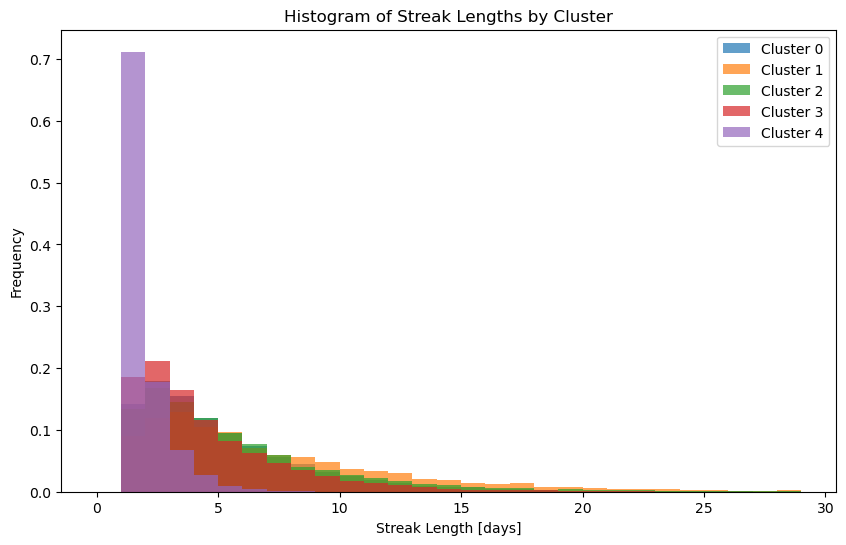

In [12]:
# Set up the figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot histograms for each cluster with different colors
for cluster_id in range(5):
    cluster_data2 = streak_lengths_Bayes[streak_lengths_Bayes['Bayes_cluster'] == cluster_id]['streak_length']
    plt.hist(cluster_data2, bins=np.arange(30), alpha=0.7, label=f'Cluster {cluster_id}', density=True)

# Add labels and title
plt.xlabel('Streak Length [days]')
plt.ylabel('Frequency')
plt.title('Histogram of Streak Lengths by Cluster')
plt.legend()

In [13]:
for i in range(5):
    print(df.query('cluster_id == @i')['correlation'].mean(), df.query('cluster_id == @i')['correlation'].std())
    print(df.query('Bayes_cluster == @i')['correlation'].mean(), df.query('Bayes_cluster == @i')['correlation'].std())

0.46894963934893097 0.1772282585860103
0.5012007394161074 0.1680488021737603
0.5271028156522817 0.1699636611794942
0.5416299300079773 0.17625505641946324
0.4410651478854981 0.18440777854187862
0.4738651308273984 0.1736254651095926
0.4352966536917132 0.17146002474743854
0.46788239069529997 0.16115586192984238
nan nan
0.3277176914481295 0.14368838547888046


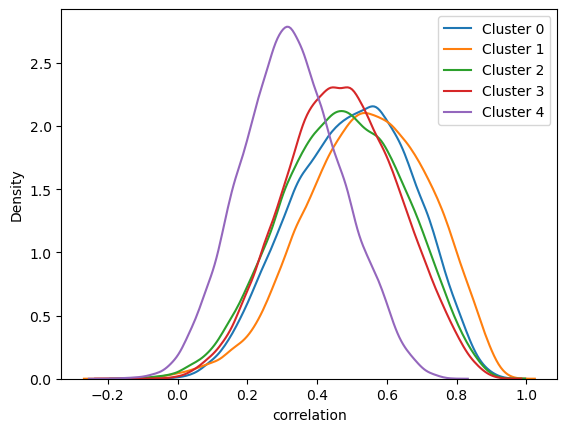

In [14]:
for i in range(5):
    sns.kdeplot(df.query('Bayes_cluster == @i')['correlation'], label = f"Cluster {i}")
plt.legend()

In [15]:
df

,time,run,cluster_id,correlation,all_errors,Bayes_cluster,Bayes_cluster_raw,date_diff,new_streak,streak_id
0,2000-01-01 09:00:00,10,3,0.654464,"[6804.388910840263, 8854.541795697962, 6885.33...",3,3,NaN,True,1
1,2000-01-02 09:00:00,10,3,0.668814,"[6912.463328492895, 8102.7727622309685, 6525.2...",3,3,1.0,False,1
2,2000-01-03 09:00:00,10,3,0.728878,"[6739.274627997818, 7275.464515336503, 6220.54...",3,3,1.0,False,1
3,2000-01-04 09:00:00,10,3,0.587739,"[6216.149194994979, 6602.016768243915, 5215.10...",3,3,1.0,False,1
4,2000-01-05 09:00:00,10,3,0.625055,"[5826.85865802202, 6382.917318530708, 4699.316...",3,3,1.0,False,1
...,...,...,...,...,...,...,...,...,...,...
1508,2009-12-27 09:00:00,169,0,0.565414,"[3860.4833958511786, 6677.049702245932, 4650.8...",0,0,4.0,True,10368
1509,2009-12-28 09:00:00,169,0,0.686435,"[3754.7070992906906, 7007.532321349696, 5372.9...",0,0,1.0,False,10368
1510,2009-12-29 09:00:00,169,0,0.626425,"[4339.751885616465, 7477.530127898548, 6025.17...",0,0,1.0,False,10368
1511,2009-12-30 09:00:00,169,0,0.542091,"[4995.074065431608, 7825.932109862418, 6643.31...",0,0,1.0,False,10368


### Appendix

In [75]:
# Not used right now, but it's an option
def cluster_length_per_country(cluster_id, country):
    streak_length_array = []
    df_events_regime = df_event_wr.query('country == @country and dominant_weather_regime == @cluster_id')
    for ind, row in tqdm(df_events_regime.iterrows()):
            run = row['run']
            start_time = pd.to_datetime(row['start_time'])
            first_time = np.where(np.array(row['weather_regime_ids']) == cluster_id)[0][0]
            streak_time = start_time + pd.Timedelta(days = first_time)
            try:
                streak_id = df.query('run == @run and time == @streak_time')['streak_id'].values[0]
                streak_length = streak_lengths_Bayes.query('Bayes_cluster == @cluster_id and streak_id == @streak_id')
                streak_length_array.append(streak_length['streak_length'].values[0])
            except IndexError:
                continue

    plt.figure()
    streak_length_all = streak_lengths_Bayes.query('Bayes_cluster == @cluster_id')['streak_length'].values
    full_mean = np.mean(streak_length_all)
    event_mean = np.mean(streak_length_array)
    plt.hist(streak_length_all, color = 'C0', alpha = 0.3)
    plt.hist(streak_length_array, color = 'r', alpha = 0.5)
    plt.axvline(event_mean, color='r', linestyle='dashed', linewidth=1, label = 'Event mean')
    plt.axvline(full_mean, color='C0', linestyle='dashed', linewidth=1, label = 'Full regime mean')
    plt.xlabel('Persistence [days]')
    plt.ylabel('Count')
    plt.title(f'Regime: {CLUSTER_NAMES[cluster_id]}')
    plt.legend()
    plt.show()

    return event_mean, full_mean